In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import tensorflow as tf


from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from PIL import Image


from tensorflow.keras import layers, losses
from pathlib import Path


In [ ]:
all_images = []
paths = [str(i) for i in Path('/content/drive/MyDrive/raw/Collageszip/').glob('*.jpg')][:1000]

for i in tqdm(paths):
    img = tf.keras.preprocessing.image.load_img(i, target_size=(384, 384, 3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255.
    all_images.append(img)

all_images = np.array(all_images)


rankings = pd.read_csv('/content/drive/MyDrive/raw/attributes.csv',
                       index_col=0).set_index('fileName').sort_index().filter(regex='_no', axis=1)


rankings = rankings.reset_index()
rankings['fileName'] = rankings['fileName'].apply(lambda x:x.split('/')[-1])
rankings = rankings.set_index('fileName')

names = [i.split('/')[-1] for i in paths]

targets = rankings.loc[[str(i) for i in names], 'charming_no']


X_train, X_test = train_test_split(all_images[(targets == 5).values], test_size=0.25)


In [ ]:
X_train.shape

(158, 384, 384, 3)

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Define the model
model = Sequential()

#1st convolution layer
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(384,384,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#2nd convolution layer
model.add(Conv2D(2,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
#-------------------------
#3rd convolution layer
model.add(Conv2D(2,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#4rd convolution layer
model.add(Conv2D(16,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#-------------------------

model.add(Conv2D(3,(3, 3), padding='same'))
model.add(Activation('sigmoid'))


# Compile the model
model.compile(optimizer='adam', loss=losses.MeanSquaredError())
batch_size = 8
    
# Train the model
model.fit(
        X_train, X_train,
        # steps_per_epoch=1000 // batch_size,
        epochs=100,
        validation_data=(X_test, X_test),
        # validation_steps=1000 // batch_size
        )
        

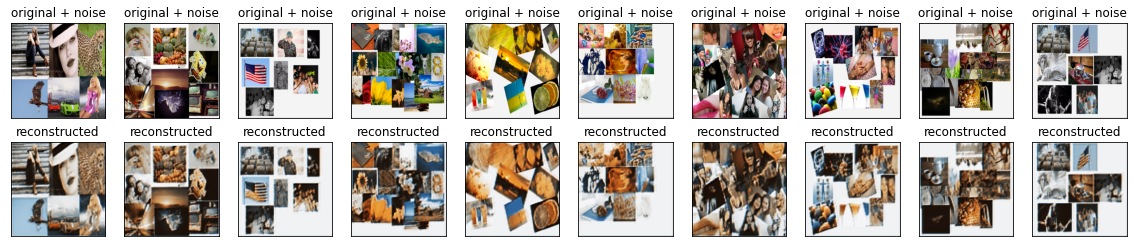

In [ ]:
decoded_imgs = model(X_test).numpy()


n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(X_test[i]))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    # plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()


In [ ]:
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(384, 384, 3)),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(2, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(2, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(X_train, X_train,
                epochs=100,
                validation_data=(X_test, X_test),
                shuffle=True)


encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()


n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(X_test[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()



In [ ]:

pred = model.predict(all_images[(targets == 1).values])

losses.MeanSquaredError()(all_images[(targets == 1).values], pred)


<tf.Tensor: shape=(), dtype=float32, numpy=0.014305239>

In [ ]:
all_images[(targets == 1).values].shape

(112, 384, 384, 3)

In [ ]:
# autoencoder.encoder()
tf.unsqueeze(all_images[(targets == 3).values][0].shape)

SyntaxError: ignored

In [ ]:
reconstructions = autoencoder.predict(all_images[(targets == 3).values])
train_loss = tf.keras.losses.mae(reconstructions, all_images[(targets == 3).values])
train_loss.numpy().mean()


0.13258821

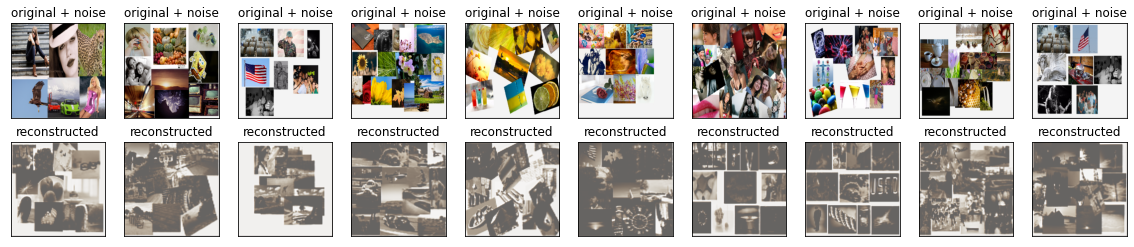

In [ ]:
encoded_imgs = autoencoder.encoder(all_images[(targets == 3).values]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()


n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(X_test[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()
